In [1]:
# To supress DPT and Mask2Former warnings
import warnings
warnings.filterwarnings("ignore")

import os
import cv2
import random

import numpy as np
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from functools import partial
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, transforms
from einops import rearrange

# Mask2Former and detectron2 dependencies for semantic segmentation pseudo labeling
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.projects.deeplab import add_deeplab_config
coco_metadata = MetadataCatalog.get("coco_2017_val_panoptic")
from mask2former import add_maskformer2_config

# DPT dependencies for depth pseudo labeling
from dpt.models import DPTDepthModel
from pipelines.utils.data_utils import preprocess_multimae_inputs
from multimae.utils.plot_utils import plot_predictions
from multimae.models.input_adapters import PatchedInputAdapter, SemSegInputAdapter
from multimae.models.output_adapters import SpatialOutputAdapter
from multimae.models.multimae import pretrain_multimae_base
from multimae.utils.data_constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

torch.set_grad_enabled(False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

vb_folder = Path(os.getcwd()) / "vision_backbones"

In [2]:
DOMAIN_CONF = {
    'rgb': {
        'input_adapter': partial(PatchedInputAdapter, num_channels=3, stride_level=1),
        'output_adapter': None,
    },
    'depth': {
        'input_adapter': partial(PatchedInputAdapter, num_channels=1, stride_level=1),
        'output_adapter': None,
    },
}
DOMAINS = ['rgb', 'depth']

input_adapters = {
    domain: dinfo['input_adapter'](
        patch_size_full=16,
    )
    for domain, dinfo in DOMAIN_CONF.items()
}

multimae = pretrain_multimae_base(
    input_adapters=input_adapters,
    output_adapters=None,
)

CKPT_URL = 'https://github.com/EPFL-VILAB/MultiMAE/releases/download/pretrained-weights/multimae-b_98_rgb+-depth-semseg_1600e_multivit-afff3f8c.pth'
ckpt = torch.hub.load_state_dict_from_url(CKPT_URL, map_location='cpu')
multimae.load_state_dict(ckpt['model'], strict=False)
multimae = multimae.to(device).eval()


## 3 MultiMAE prediction

Try out MultiMAE by loading any RGB image from a URL using this form:

## get custom test inputs

(1, 480, 640, 3)
(1, 480, 640, 1)
(1, 480, 640, 3)
0.36893076
16.56139
0.0
1.0
torch.Size([1, 3, 224, 224])
torch.Size([1, 1, 224, 224])


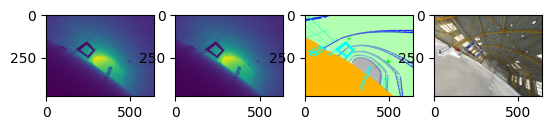

In [3]:
from pipelines.utils.data_utils import normalize2d_scale, normalize2d_robust
    
flightmare_path = Path(os.environ["FLIGHTMARE_PATH"])
data_dir = flightmare_path / "flightpy/results/tests/env_test/npz"
data_path = data_dir / "40.npz"

inputs = np.load(data_path)
img, depth, semseg = inputs["rgb"].squeeze(), inputs["depth"].squeeze(), inputs["seg"].squeeze()
# here the image is actualy stored in "bgr" format
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
semseg = cv2.cvtColor(semseg, cv2.COLOR_BGR2RGB)

print(inputs["rgb"].shape)
print(inputs["depth"].shape)
print(inputs["seg"].shape)

print(depth.min())
print(depth.max())
# print(depth)

depth_scaled = normalize2d_scale(depth)
print(depth_scaled.min())
print(depth_scaled.max())
# print(depth_scaled)

fig, axs = plt.subplots(1, 4)
axs[0].imshow(depth)
axs[1].imshow(depth_scaled)
axs[2].imshow(semseg)
axs[3].imshow(img)

input_dict = preprocess_multimae_inputs({
    "rgb": img,
    "depth": depth,
})

print(input_dict["rgb"].shape)
print(input_dict["depth"].shape)

Make predictions with a random mask. The mask is sampled during the forward pass and returned, as an output, so you can modify it manually and pass as input (see example below).

In [4]:
torch.manual_seed(1) # change seed to resample new mask
num_encoded_tokens = 196 # the number of visible tokens
alphas = 1.0 # Dirichlet concentration parameter

input_dict = {k: v.to(device) for k, v in input_dict.items()}

preds, masks = multimae.forward(input_dict, mask_inputs=False)

print(preds.shape)
masks = {domain: mask.detach().cpu() for domain, mask in masks.items()}

# masked parted has value of 1.0
print(masks["rgb"].sum())  # number of visible: 14x14 - this output
print(masks["depth"].sum())

torch.Size([1, 393, 768])
tensor(0)
tensor(0)
